<!-- Banner Image -->
<img src="https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdevnotebooks.png" width="100%">

<!-- Links -->
<center>
  <a href="https://console.brev.dev" style="color: #06b6d4;">Console</a> •
  <a href="https://brev.dev" style="color: #06b6d4;">Docs</a> •
  <a href="/" style="color: #06b6d4;">Templates</a> •
  <a href="https://discord.gg/NVDyv7TUgJ" style="color: #06b6d4;">Discord</a>
</center>

# Fine-tuning BioMistral 7B using QLoRA 🤙

Welcome!

In this notebook and tutorial, we will fine-tune the [BioMistral](https://huggingface.co/BioMistral/BioMistral-7B) model (paper [here](https://arxiv.org/abs/2402.10373), an open-source LLM trained for the medical domain. We will fine-tune it on a [Medical Q&A dataset from Hugging Face](https://huggingface.co/datasets/keivalya/MedQuad-MedicalQnADataset).

**Watch an similar video walk-through (but for Mixtral and on a different dataset) [here](https://www.youtube.com/watch?v=zbKz4g100SQ)!** If you'd like to see that notebook instead, click [here](https://github.com/brevdev/notebooks/blob/main/mixtral-finetune.ipynb).

This tutorial will use QLoRA, a fine-tuning method that combines quantization and LoRA. For more information about what those are and how they work, see [this post](https://brev.dev/blog/how-qlora-works).

In this notebook, we will load the large model in 4bit using `bitsandbytes` and use LoRA to train using the PEFT library from Hugging Face 🤗.

Note that if you ever have trouble importing something from Huggingface, you may need to run `huggingface-cli login` in a shell. To open a shell in Jupyter Lab, click on 'Launcher' (or the '+' if it's not there) next to the notebook tab at the top of the screen. Under "Other", click "Terminal" and then run the command.

### Help us make this tutorial better! Please provide feedback on the [Discord channel](https://discord.gg/y9428NwTh3) or on [X](https://x.com/harperscarroll).

#### Before we begin: A note on OOM errors

If you get an error like this: `OutOfMemoryError: CUDA out of memory`, tweak your parameters to make the model less computationally intensive. I will help guide you through that in this guide, and if you have any additional questions you can reach out on the [Discord channel](https://discord.gg/y9428NwTh3) or on [X](https://x.com/harperscarroll).

To re-try after you tweak your parameters, open a Terminal ('Launcher' or '+' in the nav bar above -> Other -> Terminal) and run the command `nvidia-smi`. Then find the process ID `PID` under `Processes` and run the command `kill [PID]`. You will need to re-start your notebook from the beginning. (There may be a better way to do this... if so please do let me know!)

## Let's begin!

I used a GPU and dev environment from [brev.dev](https://brev.dev). The whole thing cost me $1 using a 1xA10G 24GB. Click the badge below to get your preconfigured instance:

[![ Click here to deploy.](https://brev-assets.s3.us-west-1.amazonaws.com/nv-lb-dark.svg)](https://console.brev.dev/environment/new?instance=A10G:g5.xlarge&diskStorage=256&name=biomistral-finetune&file=https://github.com/brevdev/notebooks/raw/main/biomistral-finetune.ipynb&python=3.10&cuda=12.0.1)

A single A10G (as linked) or L4 should be enough for this dataset; anything with >= 24GB GPU Memory. You may need more GPUs and/or Memory if your sequence max_length is larger than 512.

Once you've checked out your machine and landed in your instance page, select the specs you'd like (I used **Python 3.10 and CUDA 12.0.1**; these should be preconfigured for you if you use the badge above) and click the "Build" button to build your verb container. Give this a few minutes.

A few minutes after your model has started Running, click the 'Notebook' button on the top right of your screen once it illuminates (you may need to refresh the screen). You will be taken to a Jupyter Lab environment, where you can upload this Notebook.


Note: You can connect your cloud credits (AWS or GCP) by clicking "Org: " on the top right, and in the panel that slides over, click "Connect AWS" or "Connect GCP" under "Connect your cloud" and follow the instructions linked to attach your credentials.



In [ ]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### 1. Load Dataset

Let's load the a [Medical Q&A Dataset from Hugging Face](https://huggingface.co/datasets/keivalya/MedQuad-MedicalQnADataset).

In [ ]:
from datasets import load_dataset

dataset = load_dataset('keivalya/MedQuad-MedicalQnADataset', split='train')
dataset = dataset.train_test_split(test_size=0.2)
train_dataset = dataset['train']
test_eval = dataset['test'].train_test_split(test_size=0.001) # just want a few test examples
eval_dataset = test_eval['train']
test_dataset = test_eval['test']

In [ ]:
print(train_dataset)
print(eval_dataset)
print(test_dataset)

Dataset({
    features: ['qtype', 'Question', 'Answer'],
    num_rows: 13125
})
Dataset({
    features: ['qtype', 'Question', 'Answer'],
    num_rows: 3278
})
Dataset({
    features: ['qtype', 'Question', 'Answer'],
    num_rows: 4
})


In [ ]:
print(test_dataset[0])

{'qtype': 'information', 'Question': 'Do you have information about Plastic and Cosmetic Surgery', 'Answer': "Summary : Surgeons can reshape the appearance of body parts through cosmetic surgery. Some of the most common body parts people want to improve through surgery include       -  Breasts: Increase or reduce the size of breasts or reshape sagging breasts     -  Ears: Reduce the size of large ears or set protruding ears back closer to the head    -  Eyes: Correct drooping upper eyelids or remove puffy bags below the eyes    -  Face: Remove facial wrinkles, creases or acne scars    -  Hair: Fill in balding areas with one's own hair    -  Nose: Change the shape of the nose     -  Tummy: Flatten the abdomen"}


### 2. Load Base Model

Let's now load BioMistral - `BioMistral/BioMistral-7B` - using 4-bit quantization!

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "BioMistral/BioMistral-7B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


### 3. Tokenization

Set up the tokenizer.

To set `max_length`, which has a direct impact on your compute requirements, it's helpful to get a distribution of your data lengths. Hugging Face shares that data clearly, like so:

![image.png](attachment:b587035d-e371-45cc-8ae2-f3f95d028ea6.png)

However, since we're combining multiple features of this dataset in `generate_and_tokenize_prompt`, let's get our own distribution of the final form of the data. Let's first tokenize without the truncation/padding, so we can get that length distribution.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_eos_token=True,
    add_bos_token=True,
)

Setup the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning):

In [ ]:
def tokenize(prompt):
    result = tokenizer(prompt)
    result["labels"] = result["input_ids"].copy()
    return result

And convert each sample into a prompt. Note that I provide an "identifier" ("From the MedQuad MedicalQA Dataset:") as I find them to be very helpful. See a video where I explain them [here](https://www.instagram.com/p/C209DnSr6hz/).

In [ ]:
def generate_and_tokenize_prompt(data_point):
    full_prompt =f"""From the MedQuad MedicalQA Dataset: Given the medical question and question type, provide an accurate answer.

### Question type:
{test_dataset[1]['qtype']}

### Question:
{data_point["Question"]}

### Answer:
{data_point["Answer"]}
"""
    return tokenize(full_prompt)


Reformat the prompt and tokenize each sample:

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/13125 [00:00<?, ? examples/s]

Map:   0%|          | 0/3278 [00:00<?, ? examples/s]

You can untokenize to make sure it was formatted properly.

In [ ]:
untokenized_text = tokenizer.decode(tokenized_train_dataset[1]['input_ids'])
print(untokenized_text)

<s> From the MedQuad MedicalQA Dataset: Given the medical question and question type, provide an accurate answer.

### Question type:
information

### Question:
What are the treatments for Breast Cancer ?

### Answer:
Certain drugs that have been used successfully in other cancers are now being used to treat some breast cancers. A mix of drugs may increase the length of time you will live, or the length of time you will live without cancer. In addition, certain drugs like Herceptin and Tykerb taken in combination with chemotherapy, can help women with specific genetic breast cancer mutations better than chemotherapy alone.
</s>


Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

16403


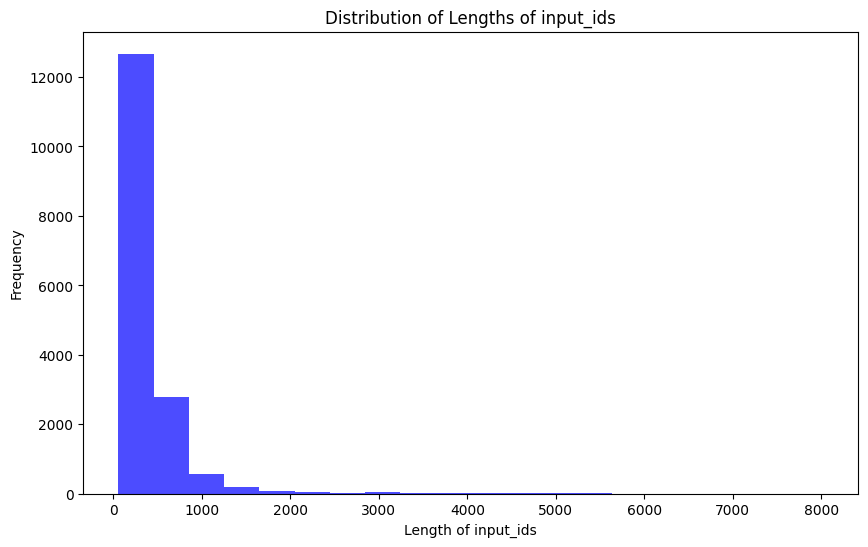

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).

In [ ]:
max_length = 512 # This was an appropriate max length for my dataset

# redefine the tokenize function and tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token


def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/13125 [00:00<?, ? examples/s]

Map:   0%|          | 0/3278 [00:00<?, ? examples/s]

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).


In [ ]:
print(tokenized_train_dataset[4]['input_ids'])

[1, 3672, 272, 2998, 2190, 316, 12195, 28824, 28741, 9888, 7369, 28747, 12628, 272, 5714, 2996, 304, 2996, 1212, 28725, 3084, 396, 11229, 4372, 28723, 13, 13, 27332, 22478, 1212, 28747, 13, 20590, 13, 13, 27332, 22478, 28747, 13, 3195, 460, 272, 12380, 302, 1896, 595, 3389, 572, 28724, 346, 1212, 334, 1550, 13, 13, 27332, 26307, 28747, 13, 3195, 460, 272, 10090, 304, 12380, 302, 1896, 595, 3389, 572, 28724, 346, 1212, 334, 28804, 415, 10649, 367, 540, 21475, 16443, 2161, 5312, 272, 2296, 1274, 302, 10090, 304, 12380, 354, 1896, 595, 3389, 572, 28724, 346, 1212, 334, 28723, 1047, 272, 1871, 349, 2632, 28725, 272, 2401, 3624, 5532, 910, 2608, 272, 10800, 300, 349, 2598, 297, 905, 395, 456, 4644, 28723, 995, 541, 938, 272, 2998, 1081, 22886, 12195, 22828, 298, 913, 582, 272, 20343, 354, 1167, 5714, 3471, 28723, 9315, 28713, 304, 12356, 447, 5185, 20047, 28744, 3314, 1474, 302, 6883, 325, 11233, 2632, 28731, 2484, 10767, 2045, 302, 272, 1424, 323, 5882, 282, 15262, 28705, 28774, 28734, 288

You can also untokenize to see it in plain text. It should start with `<s>` and end with `</s>`.

In [ ]:
untokenized_text = tokenizer.decode(tokenized_train_dataset[1]['input_ids'])
print(untokenized_text)

</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>

Now all the samples should be the same length, `max_length`.

16403


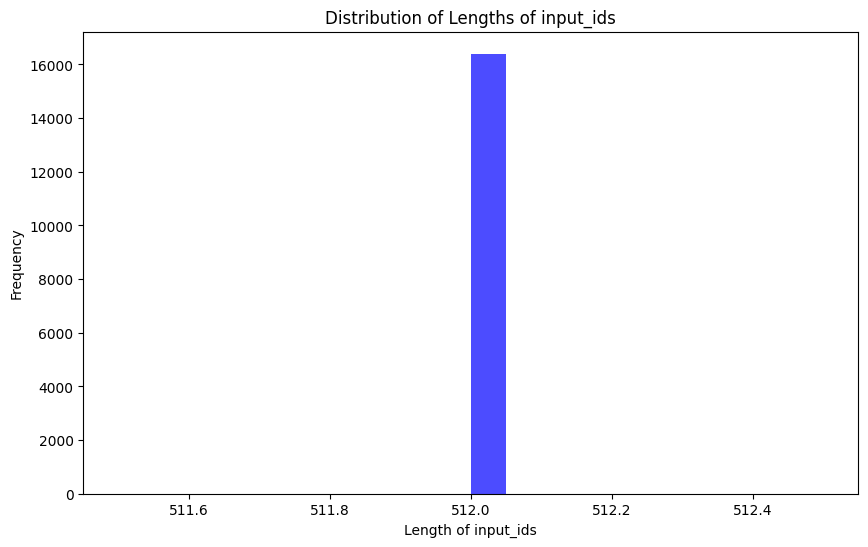

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

#### How does the base model do?

Let's grab a test input (`Question`) and desired output (`Answer`) pair to see how the base model does on it.

In [ ]:
print("Question: " + test_dataset[2]['Question'] + "\n")
print("Answer: " + test_dataset[2]['Answer'] + "\n")

Question: What are the symptoms of Norrie disease ?

Answer: What are the signs and symptoms of Norrie disease? The Human Phenotype Ontology provides the following list of signs and symptoms for Norrie disease. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Abnormality of the retinal vasculature 90% Anterior chamber synechiae 90% Aplasia/Hypoplasia of the iris 90% Cataract 90% Chorioretinal abnormality 90% Deeply set eye 90% Hypotelorism 90% Macrotia 90% Narrow nasal bridge 90% Neoplasm of the eye 90% Opacification of the corneal stroma 90% Sclerocornea 90% Vascular neoplasm 90% Abnormality of the vitreous humor 50% Aplasia/Hypoplasia of the lens 50% Cognitive impairment 50% Erectile abnormalities 50% Nystagmus 50% Retinal detachment 50% Sensorineural 

In [ ]:
eval_prompt = f"""From the MedQuad MedicalQA Dataset: Given the following medical question and question type, provide an accurate answer:

### Question type:
{test_dataset[2]['qtype']}

### Question:
{test_dataset[2]['Question']}

### Answer:
"""
print(eval_prompt)

From the MedQuad MedicalQA Dataset: Given the following medical question and question type, provide an accurate answer:

### Question type:
symptoms

### Question:
What are the symptoms of Norrie disease ?

### Answer:




In [ ]:
# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

In [ ]:
# Re-init the tokenizer so it doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

In [ ]:
device = "cuda"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to(device)

In [ ]:
model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=300)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



From the MedQuad MedicalQA Dataset: Given the following medical question and question type, provide an accurate answer:

### Question type:
symptoms

### Question:
What are the symptoms of Norrie disease ?

### Answer:
Norrie disease is a rare, X-linked recessive disorder of the blood vessels. It is characterized by the triad of retinal blindness, mental retardation, and hypertrophy of the optic disc. Norrie disease is caused by mutations in the NDP gene, which is located on the X chromosome. The symptoms of Norrie disease typically appear in infancy or early childhood. In addition to the triad of retinal blindness, mental retardation, and hypertrophy of the optic disc, other symptoms of Norrie disease may include seizures, behavioral problems, and hearing loss. The prognosis of Norrie disease is poor, and there is currently no cure or effective treatment.


We can see that out of the box, the output doesn't resemble the training data set's output.

### 4. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [ ]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=8` and `lora_alpha=16` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

trainable params: 21260288 || all params: 3773331456 || trainable%: 0.5634354746703705


See how the model looks different now, with the LoRA adapters added:

In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): L

### 5. Run Training!


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [ ]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "biomistral-finetune-identifier"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


wandb: Currently logged in as: harpercarroll. Use `wandb login --relogin` to force relogin


I used 2000 steps, but I found the model should have trained for longer as it had not converged by then, so I upped the steps to 3000 below.

A note on training. You can set the `max_steps` to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 1000 steps, and find that at around 500 steps the model starts overfitting - the validation loss goes up (bad) while the training loss goes down significantly, meaning the model is learning the training set really well, but is unable to generalize to new datapoints. Therefore, 500 steps would be your sweet spot, so you would use the `checkpoint-500` model repo in your output dir (`biomistral-medqa-finetune`) as your final model in step 6 below.

You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you didn't need to train anymore.

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

project = "medqa-finetune-identifier"
base_model_name = "biomistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=2,
        gradient_checkpointing=True,
        gradient_accumulation_steps=4,
        max_steps=3000,
        learning_rate=2.5e-5, # Want about 10x smaller than the Mistral learning rate
        logging_steps=50,
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        gradient_checkpointing_kwargs={'use_reentrant': True},
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

I cleared the output of the cell above because it was long & ugly, but the learning curves are below:

#### Learning Curves from Weights and Biases:
![image.png](attachment:d49f69b2-7e22-43f8-bfe1-b1a3c21d0426.png) ![image.png](attachment:9c3a974d-ff3f-4080-914e-fcbb4484a59d.png)

### 6. Drum Roll... Try the Trained Model!

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`).

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base Mistral model from the Huggingface Hub:


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "BioMistral/BioMistral-7B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
)

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "biomistral-medqa-finetune-identifier/checkpoint-2000")

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better. Since the training loss didn't converge, we can expect that the model won't perform excellently, but it should be at least better than the original model.

In [ ]:
eval_prompt = """From the MedQuad MedicalQA Dataset: Given the following medical question and question type, provide an accurate answer:

### Question type:
symptoms

### Question:
What are the symptoms of Norrie disease ?

### Answer:
"""

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


From the MedQuad MedicalQA Dataset: Given the following medical question and question type, provide an accurate answer:

### Question type:
symptoms

### Question:
What are the symptoms of Norrie disease ?

### Answer:
What are the signs and symptoms of Norrie disease? The Human Phenotype Ontology provides the following list of signs and symptoms for Norrie disease. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Abnormality of the retinal vasculature 90% Cataract 90% Glaucoma 90% Hearing impairment 90% Hydrocephalus 90% Microcephaly 90% Nystagmus 90% Optic atrophy 90% Visual impairment 90% Abnormality of the cochlea 50% Abnormality of the iris 50% Abnormality of the macula 50% Abnormality of the meninges 50% Abnormality of the nasal cavity 50% Abnormal

Recall that the gold-label Answer was:
> What are the signs and symptoms of Norrie disease? The Human Phenotype Ontology provides the following list of signs and symptoms for Norrie disease. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Abnormality of the retinal vasculature 90% Anterior chamber synechiae 90% Aplasia/Hypoplasia of the iris 90% Cataract 90% Chorioretinal abnormality 90% Deeply set eye 90% Hypotelorism 90% Macrotia 90% Narrow nasal bridge 90% Neoplasm of the eye 90% Opacification of the corneal stroma 90% Sclerocornea 90% Vascular neoplasm 90% Abnormality of the vitreous humor 50% Aplasia/Hypoplasia of the lens 50% Cognitive impairment 50% Erectile abnormalities 50% Nystagmus 50% Retinal detachment 50% Sensorineural hearing impairment 50% Stereotypic behavior 50% Venous insufficiency 50% Abnormality of immune system physiology 7.5% Abnormality of the diencephalon 7.5% Abnormality of the helix 7.5% Abnormality of the pupil 7.5% Aplasia/Hypoplasia of the cerebellum 7.5% Attention deficit hyperactivity disorder 7.5% Autism 7.5% Cerebral cortical atrophy 7.5% Cryptorchidism 7.5% Decreased body weight 7.5% Developmental regression 7.5% Diabetes mellitus 7.5% Ectopia lentis 7.5% EEG abnormality 7.5% Glaucoma 7.5% Hallucinations 7.5% Hyperreflexia 7.5% Hypertonia 7.5% Hypoplasia of the zygomatic bone 7.5% Involuntary movements 7.5% Microcephaly 7.5% Migraine 7.5% Muscle weakness 7.5% Muscular hypotonia 7.5% Optic atrophy 7.5% Scoliosis 7.5% Seizures 7.5% Self-injurious behavior 7.5% Sleep disturbance 7.5% Thin vermilion border 7.5% Aggressive behavior - Blindness - Dementia - Hypoplasia of the iris - Intellectual disability, progressive - Microphthalmia - Psychosis - Retinal dysplasia - Retinal fold - Shallow anterior chamber - X-linked recessive inheritance - The Human Phenotype Ontology (HPO) has collected information on how often a sign or symptom occurs in a condition. Much of this information comes from Orphanet, a European rare disease database. The frequency of a sign or symptom is usually listed as a rough estimate of the percentage of patients who have that feature. The frequency may also be listed as a fraction. The first number of the fraction is how many people had the symptom, and the second number is the total number of people who were examined in one study. For example, a frequency of 25/25 means that in a study of 25 people all patients were found to have that symptom. Because these frequencies are based on a specific study, the fractions may be different if another group of patients are examined. Sometimes, no information on frequency is available. In these cases, the sign or symptom may be rare or common.

and out of the box, the model's output was:
> Norrie disease is a rare, X-linked recessive disorder of the blood vessels. It is characterized by the triad of retinal blindness, mental retardation, and hypertrophy of the optic disc. Norrie disease is caused by mutations in the NDP gene, which is located on the X chromosome. The symptoms of Norrie disease typically appear in infancy or early childhood. In addition to the triad of retinal blindness, mental retardation, and hypertrophy of the optic disc, other symptoms of Norrie disease may include seizures, behavioral problems, and hearing loss. The prognosis of Norrie disease is poor, and there is currently no cure or effective treatment.

The fine-tuned model responds:
> What are the signs and symptoms of Norrie disease? The Human Phenotype Ontology provides the following list of signs and symptoms for Norrie disease. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Abnormality of the retinal vasculature 90% Cataract 90% Glaucoma 90% Hearing impairment 90% Hydrocephalus 90% Microcephaly 90% Nystagmus 90% Optic atrophy 90% Visual impairment 90% Abnormality of the cochlea 50% Abnormality of the iris 50% Abnormality of the macula 50% Abnormality of the meninges 50% Abnormality of the nasal cavity 50% Abnormality of the nasopharynx 50% Abnormality of the palate 50% Abnormality of the pinna 50% Abnormality of the thorax 50% Abnormality of the ureter 50% Abnormality of the urinary tract 50

Therefore, we can see that our fine-tuned model has definitely learned from the training data. It provides a list of symptoms with percentages, and likely would have generated an output of a similar length to the gold label Answer if we had increased the `max_new_tokens`.

### Sweet... it worked! We learned how to respond in the form of our training data!

I hope you enjoyed this tutorial on fine-tuning BioMistral. If you have any questions, feel free to reach out to me on [X](https://x.com/harperscarroll) or on the [Discord channel](https://discord.gg/y9428NwTh3).

🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙